In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics
import math

In [2]:
def max_index(lst):
    """Returns the index of the maximum element in the given list"""
    max_val = max(lst)
    max_idx = lst.index(max_val)
    return max_idx

def choose(keys,values,model_l,my_dict,X_input,lr_model,lag):
    date_string=''
    reverse_index=[]
    for j in range(len(values)):
        if values[j]<0.5:
            values[j]=1-values[j]
            reverse_index.append(j)
    i=max_index(values)
    model=model_l[i]
    print('The highest accuracy is', keys[i] )
    print('The value is ',values[i])
    print('Choosing model: ',model)
    X_today=X_input.values
    time=X_input.index[0]
    date_string = time.strftime('%Y-%m-%d %H:%M:%S')
    date_string =date_string[:10]
    
    if model==lr_model:
        
        #print(df['Close'][-1])
        #lr_model.fit()
        lr_pred = np.where(lr_model.predict(X_today) > 0.5, 1, 0)
        
        print('Input Date: ', date_string)
        print('---------')
        #print(logreg_pred)
        if lr_pred[0]>0:
            print('Close price will go up '+ str(lag)+ ' trading day after '+ date_string)
        else:
            print('Close price will go down '+ str(lag)+ ' trading day after '+ date_string)
        result= lr_pred[0]
    else:
        #model.fit(X_train, y_train)
        model_pred = model.predict(X_today)
        
        if model_pred[0]>0:
            print('Close price will go up '+ str(lag)+ ' trading day after '+ date_string)
        else:
            print('Close price will go down '+ str(lag)+ ' trading day after '+ date_string)
        result=model_pred[0]
    if i in reverse_index:
        print('reverse for above!!!')
        if result==1:
            result=0
        else:
            result=1
    return result

def choose_v(keys,values,model_l,my_dict,X_input,lr_model,lag):
    date_string=''
    reverse=0
    '''
    if max(values)<0.5:
        reverse=1
        for j in range(len(values)):
            if values[j]<0.5:
                values[j]=1-values[j]
    '''
    reverse_index=[]
    for j in range(len(values)):
        if values[j]<0.5:
            values[j]=1-values[j]
            reverse_index.append(j)
    i=max_index(values)
    model=model_l[i]
    X_today=X_input.values
    time=X_input.index[0]
    date_string = time.strftime('%Y-%m-%d %H:%M:%S')
    date_string =date_string[:10]
    if model==lr_model:
        
        #print(df['Close'][-1])
        #lr_model.fit()
        lr_pred = np.where(lr_model.predict(X_today) > 0.5, 1, 0)
        
       
        result= lr_pred[0]
    else:
        #model.fit(X_train, y_train)
        model_pred = model.predict(X_today)
        result=model_pred[0]
    #print(keys[i])
    if i in reverse_index:
        if result==1:
            result=0
        else:  # when result==0
            result=1
    return (result,values[i])

In [3]:
def main_draw(lag=1):
    last=-1
    #year='5y'
    year='3y'
    # 从yfinance API获取股票、国债和黄金数据
    tqqq = yf.Ticker('TQQQ')
    tqqq_df = tqqq.history(period=year)
    bond = yf.Ticker('^TNX')
    bond_df = bond.history(period=year)
    gold = yf.Ticker('GC=F')
    gold_df = gold.history(period=year)
    tesla = yf.Ticker('TSLA')
    tesla_df = tesla.history(period=year)
    
    # 计算五日均线
    tqqq_df['5_day_avg'] = tqqq_df['Close'].rolling(window=5).mean()
    bond_df['5_day_avg'] = bond_df['Close'].rolling(window=5).mean()
    gold_df['5_day_avg'] = gold_df['Close'].rolling(window=5).mean()
    tesla_df['5_day_avg'] = tesla_df['Close'].rolling(window=5).mean()
    
    # 合并所有数据
    df = pd.DataFrame(index=tqqq_df.index)
    df['Close']=tqqq_df['Close']
    
    df['Open'] = tqqq_df['Open']
    df['High'] = tqqq_df['High']
    df['Low'] = tqqq_df['Low']
    df['Volume'] = tqqq_df['Volume']
    df['TQQQ_5_day_avg'] = tqqq_df['5_day_avg']
    df['Bond_5_day_avg'] = bond_df['5_day_avg']
    df['Gold_5_day_avg'] = gold_df['5_day_avg']
    df['Tesla_5_day_avg'] = tesla_df['5_day_avg']
    
    # 去掉有缺失值的行
    df.dropna(inplace=True)
    o_df=df.copy()
    #df=df.iloc[:-1]  # remove today.  should remove this line (if at night), just now because it is in the trading time
    # used N-1 day for the end of sample data, so [:last]
    df=df.iloc[:last] 
    # 计算涨跌情况
    
    df['Price_Change'] = np.where(df['Close'].diff() > 0, 1, 0)
    
    # 用昨天的数据预测今天的收盘价涨跌情况
    df_close=df[['Close','Open', 'High', 'Low', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[:-1]
    
    o_X_df=o_df[['Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']]
    
    
    # train data
    X_df=df[['Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[:-lag]
    X = df[['Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[:-lag].values
    y = df['Price_Change'].iloc[lag:].values
    
    today_Xdf=o_df[['Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[-1:,:]
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # 线性回归模型
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = np.where(lr_model.predict(X_test) > 0.5, 1, 0)
    
    # 逻辑回归模型
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)
    logreg_pred = logreg_model.predict(X_test)
    
    # 随机森林模型
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    '''
    # 时间序列模型 (ARIMA)
    ts_model = ARIMA(y_train, order=(1, 0, 0))
    ts_model_fit = ts_model.fit()
    ts_pred = np.where(ts_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1) > 0, 1, 0)
    '''
    # 计算准确率
    lr_accuracy = accuracy_score(y_test, lr_pred)
    logreg_accuracy = accuracy_score(y_test, logreg_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    #ts_accuracy = accuracy_score(y_test, ts_pred)
    
    
    #print("Linear Regression Accuracy: {:.2f}%".format(lr_accuracy * 100))
    #print("Random Forest Accuracy: {:.2f}%".format(rf_accuracy * 100))
    #print("Time Series (ARIMA) Accuracy: {:.3f}%".format(ts_accuracy * 100))
    #print("Logistic Regression Accuracy: {:.3f}%".format(logreg_accuracy * 100))
    #print('--------')
    #t_df=X_df.iloc[-1,:]
    time=X_df.index[-1]
    
    date_str = time.strftime('%Y-%m-%d %H:%M:%S')
    date_str =date_str[:10]
    #print('Train Data Last Date: ', date_str)
    #print('--------')
    keys=['lr_accuracy', 'rf_accuracy' ,'logreg_accuracy']
    values=[lr_accuracy, rf_accuracy, logreg_accuracy]
    model_l=[lr_model,rf_model,logreg_model]
    name_model_l=['lr_model','rf_model','logreg_model']
    my_dict = dict(zip(keys, model_l))
    #X_input=X_df.iloc[-1:, :]
    #choose(keys,values,model_l,my_dict,today_Xdf,lr_model,lag)
    
    #print(today_Xdf)
    return choose_v(keys,values,model_l,my_dict,today_Xdf,lr_model,lag)
main_draw(7)

(1, 0.5771812080536913)

# Change scale according to recent std

In [4]:
year='3d'
# 从yfinance API获取股票、国债和黄金数据
tqqq = yf.Ticker('TQQQ')
tqqq_df = tqqq.history(period=year)
price_data=tqqq_df['Close']
percent_change = price_data.pct_change()

print(math.sqrt(statistics.variance(percent_change[1:])))
#percent_change

0.007480584263364242


In [5]:
np.mean(percent_change[1:])
print(math.sqrt(statistics.variance(tqqq_df['Close'])))

0.40163213388872837


In [6]:
year='3d'
# 从yfinance API获取股票、国债和黄金数据
tqqq = yf.Ticker('TQQQ')
tqqq_df = tqqq.history(period=year)
price_data=tqqq_df['Close']
print(math.sqrt(statistics.variance(tqqq_df['Close'])))

0.39950009388288515


In [7]:
price_data
time=price_data.index[-1]
date_string = time.strftime('%Y-%m-%d %H:%M:%S')
date_string =date_string[:10]
date_string

'2023-05-04'

26.635000228881836
Accuracy for the up-down: 0.5629139072847682 after 1 Day(s)
26.654818682369807
Accuracy for the up-down: 0.5533333333333333 after 2 Day(s)
27.015844964906268
Accuracy for the up-down: 0.62 after 3 Day(s)
27.08769280821525
Accuracy for the up-down: 0.6 after 4 Day(s)
27.447846625186557
Accuracy for the up-down: 0.5533333333333333 after 5 Day(s)
27.53167579160292
Accuracy for the up-down: 0.6333333333333333 after 6 Day(s)
27.59382894001746
Accuracy for the up-down: 0.6241610738255033 after 7 Day(s)
27.645904724720882
Accuracy for the up-down: 0.5436241610738255 after 8 Day(s)
28.06117871564779
Accuracy for the up-down: 0.5906040268456376 after 9 Day(s)
28.13391117716466
Accuracy for the up-down: 0.5436241610738255 after 10 Day(s)
28.740602110535796
Accuracy for the up-down: 0.5570469798657718 after 11 Day(s)
29.29558520443845
Accuracy for the up-down: 0.5743243243243243 after 12 Day(s)
29.673291625860713
Accuracy for the up-down: 0.581081081081081 after 13 Day(s)
29.78

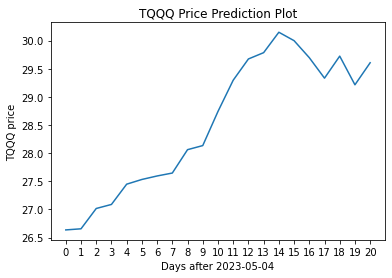

In [8]:
year='3d'
# 从yfinance API获取股票、国债和黄金数据
tqqq = yf.Ticker('TQQQ')
tqqq_df = tqqq.history(period=year)
price_data=tqqq_df['Close']
numbers = [i for i in range(1, 21)]
xl=[i for i in range(0, 21)]
#price=today_Xdf['Open'][0]
#price=27.04
price=price_data[-1]
price0=27.45
price_l=[price]

time=price_data.index[-1]
date_string = time.strftime('%Y-%m-%d %H:%M:%S')
date_string =date_string[:10]
date_string

for i in numbers:
    random_number = np.random.normal(loc=0, scale=math.sqrt(statistics.variance(price_data)))
    random_number=abs(random_number)
    up_down,acu=main_draw(i)
    print(price)
    print("Accuracy for the up-down: "+ str(acu) + ' after ' + str(i) + ' Day(s)')
    #print('here')
    if up_down>0:
        price= price+random_number
    else:
        price=price-random_number
    
    price_l.append(price)

# Create two lists of data
#x_values = [0]+numbers
y_values = price_l
plt.xticks(range(0, 21))
# Create a line plot
plt.plot(xl,y_values)

# Add labels and title
plt.xlabel('Days after '+date_string)
plt.ylabel('TQQQ price')
plt.title('TQQQ Price Prediction Plot')

# Show the plot
plt.show()

# Detail info

In [13]:
def main(lag=1):
    last=-1
    #year='5y'
    year='3y'
    # 从yfinance API获取股票、国债和黄金数据
    tqqq = yf.Ticker('TQQQ')
    tqqq_df = tqqq.history(period=year)
    bond = yf.Ticker('^TNX')
    bond_df = bond.history(period=year)
    gold = yf.Ticker('GC=F')
    gold_df = gold.history(period=year)
    tesla = yf.Ticker('TSLA')
    tesla_df = tesla.history(period=year)
    
    # 计算五日均线
    tqqq_df['5_day_avg'] = tqqq_df['Close'].rolling(window=5).mean()
    bond_df['5_day_avg'] = bond_df['Close'].rolling(window=5).mean()
    gold_df['5_day_avg'] = gold_df['Close'].rolling(window=5).mean()
    tesla_df['5_day_avg'] = tesla_df['Close'].rolling(window=5).mean()
    
    # 合并所有数据
    df = pd.DataFrame(index=tqqq_df.index)
    df['Close']=tqqq_df['Close']
    df['Open'] = tqqq_df['Open']
    df['High'] = tqqq_df['High']
    df['Low'] = tqqq_df['Low']
    df['Volume'] = tqqq_df['Volume']
    df['TQQQ_5_day_avg'] = tqqq_df['5_day_avg']
    df['Bond_5_day_avg'] = bond_df['5_day_avg']
    df['Gold_5_day_avg'] = gold_df['5_day_avg']
    df['Tesla_5_day_avg'] = tesla_df['5_day_avg']
    
    # 去掉有缺失值的行
    df.dropna(inplace=True)
    o_df=df.copy()
    #df=df.iloc[:-1]  # remove today.  should remove this line (if at night), just now because it is in the trading time
    # used N-1 day for the end of sample data
    df=df.iloc[:last] 
    # 计算涨跌情况
    
    df['Price_Change'] = np.where(df['Close'].diff() > 0, 1, 0)
    
    # 用昨天的数据预测今天的收盘价涨跌情况
    df_close=df[['Close','Open', 'High', 'Low', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[:-1]
    
    o_X_df=o_df[['Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']]
    
    
    # train data
    X_df=df[['Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[:-lag]
    X = df[['Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[:-lag].values
    y = df['Price_Change'].iloc[lag:].values
    
    today_Xdf=o_df[['Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[-1:,:]
    today_close=o_df[['Close','Open', 'Volume', 'TQQQ_5_day_avg', 'Bond_5_day_avg', 'Gold_5_day_avg', 'Tesla_5_day_avg']].iloc[-1:,:]
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    # 线性回归模型
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = np.where(lr_model.predict(X_test) > 0.5, 1, 0)
    
    # 逻辑回归模型
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)
    logreg_pred = logreg_model.predict(X_test)
    
    # 随机森林模型
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    '''
    # 时间序列模型 (ARIMA)
    ts_model = ARIMA(y_train, order=(1, 0, 0))
    ts_model_fit = ts_model.fit()
    ts_pred = np.where(ts_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1) > 0, 1, 0)
    '''
    # 计算准确率
    lr_accuracy = accuracy_score(y_test, lr_pred)
    logreg_accuracy = accuracy_score(y_test, logreg_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    #ts_accuracy = accuracy_score(y_test, ts_pred)
    
    
    print("Linear Regression Accuracy: {:.2f}%".format(lr_accuracy * 100))
    print("Random Forest Accuracy: {:.2f}%".format(rf_accuracy * 100))
    #print("Time Series (ARIMA) Accuracy: {:.3f}%".format(ts_accuracy * 100))
    print("Logistic Regression Accuracy: {:.3f}%".format(logreg_accuracy * 100))
    print('--------')
    #t_df=X_df.iloc[-1,:]
    time=X_df.index[-1]
    
    date_str = time.strftime('%Y-%m-%d %H:%M:%S')
    date_str =date_str[:10]
    print('Train Data Last Date: ', date_str)
    print('--------')
    keys=['lr_accuracy', 'rf_accuracy' ,'logreg_accuracy']
    values=[lr_accuracy, rf_accuracy, logreg_accuracy]
    model_l=[lr_model,rf_model,logreg_model]
    name_model_l=['lr_model','rf_model','logreg_model']
    my_dict = dict(zip(keys, model_l))
    #X_input=X_df.iloc[-1:, :]
    #choose(keys,values,model_l,my_dict,today_Xdf,lr_model,lag)
    print('---------')
    print("Today's close price:")
    print(today_close)
    return choose(keys,values,model_l,my_dict,today_Xdf,lr_model,lag)
main(1)

Linear Regression Accuracy: 64.47%
Random Forest Accuracy: 47.37%
Logistic Regression Accuracy: 52.632%
--------
Train Data Last Date:  2023-05-02
--------
---------
Today's close price:
                               Close       Open    Volume  TQQQ_5_day_avg  \
Date                                                                        
2023-05-04 00:00:00-04:00  26.629999  26.780001  69164030           27.47   

                           Bond_5_day_avg  Gold_5_day_avg  Tesla_5_day_avg  
Date                                                                        
2023-05-04 00:00:00-04:00          3.4374     2015.100024          161.528  
The highest accuracy is lr_accuracy
The value is  0.6447368421052632
Choosing model:  LinearRegression()
Input Date:  2023-05-04
---------
Close price will go up 1 trading day after 2023-05-04


1